# Analyze and plot methods for hurricane forecast uncertainty
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria

## Python setup

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash
from build_data import build_hurricane_data
import build_model
import model_diagnostics
from silence_tensorflow import silence_tensorflow
import prediction
from sklearn.neighbors import KernelDensity
import pandas as pd
from tqdm import tqdm
import analysis_plots
from scipy import stats
from toolbox import custom_round, ceiling_round
import seaborn as sns

import imp
import warnings
warnings.filterwarnings("ignore")
silence_tensorflow()
dpiFig = 400

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## User parameters

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "18 March 2022"

EXP_NAME_LIST = (
                 "intensity302_EPCP48",    
                 "intensity312_EPCP48",    
                 "intensity322_EPCP48",        
                 )
PLOT_SEED_VECTOR = {"intensity302_EPCP48": 416,
                    "intensity312_EPCP48": 416,
                    "intensity322_EPCP48": 416,                                       
                   }


APPEND_NAME = ''#'_paper'

SHASH_INCS = np.arange(-160,161,1)
DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "saved_metrics/"
FIGURE_PATH = "figures/paper_figures/"
PREDICTION_PATH = "saved_predictions/"


## Plotting functions

In [3]:
FS = 16

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

In [4]:
def get_storm_details(df, isample):
    storm = df.iloc[isample]
    storm_name = storm['Name']
    storm_ftime = storm['ftime(hr)']
    storm_month = str(storm['time'])[:-4]
    storm_day = str(storm['time'])[-4:-2]
    storm_hour = str(storm['time'])[-2:]
    storm_year = storm['year']

    details = storm_name + ' ' + str(storm_year) + '-' + str(storm_month) + '-' + str(storm_day) + ' ' + str(storm_hour) + '00 @' + str(storm_ftime) + 'hr'
    
    return details

In [5]:
def plot_iqr_vs_error(ax,model, x_eval, onehot_eval, df_eval, yvar="shash_error"):
    # make predictions
    mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params(x_eval, model)    

    # convert y_pred to intensity corrections    
    ann_correction  = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.5)
    true_correction = df_eval['OBDV'].to_numpy()  

    # convert to full intensity predictions
    cons_intensity  = df_eval['VMXC'].to_numpy()
    ann_intensity   = cons_intensity + ann_correction
    true_intensity  = cons_intensity + true_correction

    # compute errors
    shash_error  = np.abs(ann_intensity - true_intensity)
    cons_error = np.abs(cons_intensity - true_intensity)

    # covert shash prediction bounds
    shash_low_correction  = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.25)
    shash_high_correction = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.75)
    iqr                   = shash_high_correction - shash_low_correction

    print(stats.spearmanr(iqr,shash_error))
    print(stats.pearsonr(iqr,shash_error))

    df_eval['iqr'] = iqr
    df_eval['shash_error'] = shash_error
    df_eval['cons_error'] = cons_error

    #------------------------------------------------------------------------------------
    ROUND_BASE = 10

    df_plot = df_eval.copy()
    df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: custom_round(x, base=ROUND_BASE))
    df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: ceiling_round(x, ceiling=30))
    #-----------------------------------------------------------------------------
    clr = "teal"
    if(yvar=="cons_error"):
        clr = "orange"
    
    
    
    for xvar in ('iqr',):#('sigma', 'range_66'):
        g = sns.boxplot(
            ax=ax,
            data=df_plot,
            x=xvar, y=yvar,
            whis=None,
            fliersize=0,
            boxprops={'alpha':.2,
                      'edgecolor': 'gray',
                      'color': 'gray',
                     },
        )      
        plt.setp(g.artists, edgecolor = '.4', facecolor='.95')
        plt.setp(g.lines, color='.4')
        ax = sns.stripplot(ax=ax,x=xvar, y=yvar, data=df_plot, color=clr, size=3.,alpha=.75,)
        # plt.axhline(y=0,color='k', alpha=.25, linewidth=1)

        # g.set_xlim(-.5,6.5)

        ax.set_xlabel('ANN Predicted IQR [knots]')
        if(yvar=="cons_error"):
            ax.set_title('(c) Consensus Error vs ANN Predicted Uncertainty', fontsize=FS, color='k')    
            ax.set_ylabel('Consensus Absolute Error [knots]')
        else:
            ax.set_title('(b) ANN Error vs ANN Predicted Uncertainty', fontsize=FS, color='k')            
            ax.set_ylabel('ANN Absolute Error [knots]')        



## Network functions

In [6]:
def load_model():
    model_name = (
        exp_name + "_" + 
        str(testing_years) + '_' +
        settings["uncertainty_type"] + '_' + 
        f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
    )
    pprint.pprint(model_name)
    
    if settings["uncertainty_type"] == "bnn":       
        model = build_model.build_bnn_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            act_fun=settings["act_fun"],
        )
        
    elif settings["uncertainty_type"] == "mcdrop":       
        model = build_model.build_mcdrop_model(
            x_train,
            onehot_train,
            dropout_rate=settings["dropout_rate"],                
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            act_fun=settings["act_fun"],
        )

    elif settings["uncertainty_type"][:5] == "shash": 
        model = build_model.build_shash_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        
    model.load_weights(MODEL_PATH + model_name + "_weights.h5")
        
    return model, model_name

In [7]:
def get_predictions(model, x_eval):
    runs = 5_000
    shash_cpd = np.zeros((np.shape(x_eval)[0],len(SHASH_INCS)))
    shash_med = np.zeros((np.shape(x_eval)[0],))
    mc_cpd = np.zeros((np.shape(x_eval)[0],runs))
    tf.random.set_seed(network_seed)

    if settings["uncertainty_type"] == "bnn":               
        for i in tqdm(range(0,runs)):
            mc_cpd[:,i] = np.reshape(model.predict(x_eval),np.shape(mc_cpd)[0])
        return mc_cpd, np.median(mc_cpd,axis=1)
    
    elif settings["uncertainty_type"] == "mcdrop":  
        # loop through runs for mcdrop calculation  
        for i in tqdm(range(0,runs)):
            mc_cpd[:,i] = np.reshape(model(x_eval,training=True),np.shape(mc_cpd)[0])    
        return mc_cpd, np.median(mc_cpd,axis=1)
    
    elif settings["uncertainty_type"][:5] == "shash": 
        # loop through samples for shash calculation and get PDF for each sample
        for j in tqdm(range(0,np.shape(shash_cpd)[0])):
            mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_eval[np.newaxis,j], model )
            shash_cpd[j,:] = shash.prob(SHASH_INCS, mu_pred, sigma_pred, gamma_pred, tau_pred)    
            shash_med[j]   = shash.median(mu_pred,sigma_pred,gamma_pred,tau_pred)
        return shash_cpd, shash_med
    
    else:
        raise NotImplementedError('no such uncertainty type')


## Load the models

In [9]:
pred_dict = {}
for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)

    # set testing data
    if settings["test_condition"] == "leave-one-out":
        TESTING_YEARS_LIST = np.arange(2020,2021)
    elif settings["test_condition"] == "years":
        TESTING_YEARS_LIST = (np.copy(settings["years_test"]))
    else:
        raise NotImplementError('no such testing condition')
        
    
    for testing_years in TESTING_YEARS_LIST:        
        # set testing year
        settings["years_test"] = (testing_years,)
    
    
        for rng_seed in settings["rng_seed_list"]:
            
            if rng_seed != PLOT_SEED_VECTOR[exp_name]:
                continue
            seed_dict = {}
            settings['rng_seed'] = rng_seed
            NETWORK_SEED_LIST = [settings["rng_seed"]]
            network_seed = NETWORK_SEED_LIST[0]

            # get the data
            (
                data_summary,        
                x_train,
                onehot_train,
                x_val,
                onehot_val,
                x_test,
                onehot_test,        
                x_valtest,
                onehot_valtest,
                df_train,
                df_val,
                df_test,
                df_valtest,
            ) = build_hurricane_data(DATA_PATH, settings, verbose=0)
            # x_eval, onehot_eval, df_eval = x_test, onehot_test, df_test

            # load the correct model
            model,model_name = load_model()

            # get predictions
            pred_test = get_predictions(model, x_test)
            # pred_valtest = get_predictions(model, x_valtest)

            seed_dict[network_seed] = {'pred_cpd_test': pred_test[0], 
                                       'pred_med_test': pred_test[1],
                                       # 'pred_cpd_valtest': pred_valtest[0], 
                                       # 'pred_med_valtest': pred_valtest[1], 
                                      }    
            pred_dict[exp_name] = seed_dict

print(pred_dict.keys())
# pred_dict['paper1_EPCP96'][605]['pred_cpd']

'intensity302_EPCP48_2020_shash3_network_seed_416_rng_seed_416'


100%|█████████████████████████████████████████| 124/124 [00:04<00:00, 25.50it/s]


'intensity312_EPCP48_2020_bnn_network_seed_416_rng_seed_416'


100%|███████████████████████████████████████| 5000/5000 [03:13<00:00, 25.83it/s]


'intensity322_EPCP48_2020_mcdrop_network_seed_416_rng_seed_416'


100%|██████████████████████████████████████| 5000/5000 [00:09<00:00, 513.75it/s]

dict_keys(['intensity302_EPCP48', 'intensity312_EPCP48', 'intensity322_EPCP48'])


In [10]:
pred_dict.keys()

dict_keys(['intensity302_EPCP48', 'intensity312_EPCP48', 'intensity322_EPCP48'])

## Plot example comparison predictions

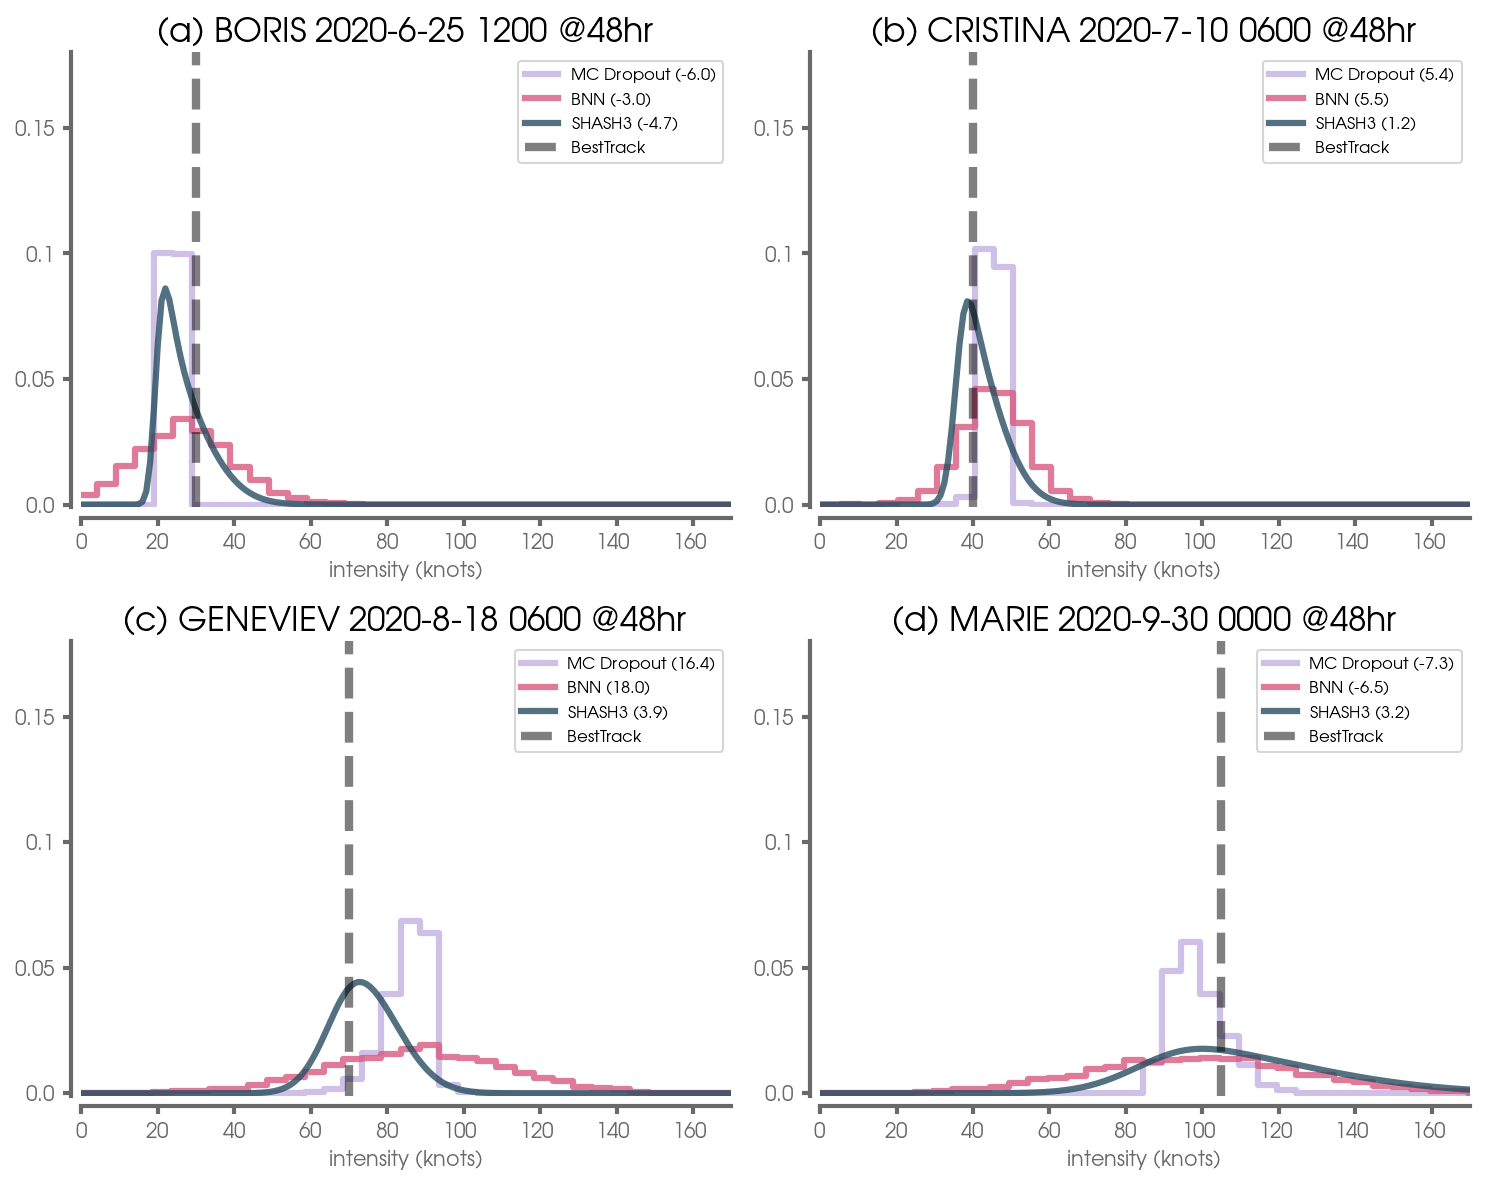

In [19]:
# PLOTTING TESTING DATA ONLY
PLOT_SEED = 416
colors = ('#284E60','#D95980','#C3B1E1')
imp.reload(analysis_plots)
panel_letters = ('(a)','(b)','(c)','(d)')
alpha_val = .8
LW = 3

f, axs = plt.subplots(2, 2, figsize=(10,8))
axs = axs.flatten()
# random_samples = (173,140,6,130) #AL @72
random_samples = (13,65,6,90)#(17,65,6,90)#(25,88,111,27) # (30,88,110,44)(25,88,110,27)

true_intensity = df_test["VMXC"] + df_test["OBDV"]
cons_intensity = df_test["VMXC"]

exp_name_shash = 'intensity302_EPCP48'
exp_name_bnn = 'intensity312_EPCP48'
exp_name_mcdrop = 'intensity322_EPCP48'

for isample, sample in enumerate(random_samples):
    
    ax = axs[isample]
    
    # plot MC-DROP
    bnn_bins = np.arange(-200,200,5)
    bnn_bin_inc = bnn_bins[1]-bnn_bins[0]    
    hmcdrop = np.histogram(pred_dict[exp_name_mcdrop][PLOT_SEED]['pred_cpd_test'][sample,:],
                   bins=bnn_bins)[0]/(bnn_bin_inc*pred_dict[exp_name_mcdrop][PLOT_SEED]['pred_cpd_test'][sample,:].shape[0])
    mcdrop_error = np.median(pred_dict[exp_name_mcdrop][PLOT_SEED]['pred_cpd_test'][sample,:]-onehot_test[sample,0])
    ax.step(bnn_bins[1:]+cons_intensity[sample],
            hmcdrop,
            color=colors[2],
            linewidth=LW,
            label='MC Dropout (' + str(mcdrop_error.round(1)) + ')',
            alpha=alpha_val,            
           )
    # plot BNN    
    hbnn = np.histogram(pred_dict[exp_name_bnn][PLOT_SEED]['pred_cpd_test'][sample,:],
                   bins=bnn_bins)[0]/(bnn_bin_inc*pred_dict[exp_name_bnn][PLOT_SEED]['pred_cpd_test'][sample,:].shape[0])
    bnn_error = np.median(pred_dict[exp_name_bnn][PLOT_SEED]['pred_cpd_test'][sample,:]-onehot_test[sample,0])
    ax.step(bnn_bins[1:]+cons_intensity[sample],
            hbnn,
            color=colors[1],
            linewidth=LW,
            label='BNN (' + str(bnn_error.round(1)) + ')',
            alpha=alpha_val,            
           )    
    
    # plot SHASH
    ann_error = pred_dict[exp_name_shash][PLOT_SEED]['pred_med_test'][sample]-onehot_test[sample,0]    
    ax.plot(SHASH_INCS+cons_intensity[sample],pred_dict[exp_name_shash][PLOT_SEED]['pred_cpd_test'][sample,:],
            color=colors[0],
            linewidth=LW,
            label='SHASH3 (' + str(ann_error.round(1)) + ')',
            alpha=alpha_val,
           )

    
    ax.axvline(x=true_intensity[sample],
               linestyle='--',               
               color='k',
               alpha=.5,
               linewidth=4,               
               label='BestTrack',
              )
    
    details = get_storm_details(df_test, sample)
    ax.set_title(panel_letters[isample] + ' ' + details, fontsize=FS, color='k')
    ax.legend(fontsize=8)
    ax.set_xlabel('intensity (knots)')
    ax.set_xticks(np.arange(0,180,20),np.arange(0,180,20))
    ax.set_yticks(np.arange(0,.25,.05),np.arange(0,.25,.05).round(2))    
    ax.set_xlim(0,170)
    ax.set_ylim(-.001,.18)
    format_spines(ax)
    
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'uq_compare_exampleDistributions_' + EXP_NAME_LIST[0] + '_seed' + str(PLOT_SEED) + '.png', dpi=dpiFig)    
plt.show()   